# Beberapa Contoh Penerapan Neural Network

- Menggunakan bahasa pemrograman python
- Bisa menggunakan library **TensorFlow** atau **PyTorch**
- **TensorFlow** dan **PyTorch**: Python library untuk Machine Learning. Termasuk di dalamnya ada Neural Network (NN)
- [https://www.tensorflow.org/](https://www.tensorflow.org/)
- [https://pytorch.org/](https://pytorch.org/)

![](img/img7a.png)
![](img/img7b.png)

- Cara install library **TensorFlow**:

`pip install tensorflow`

- Cara install library **PyTorch** jika memiliki GPU

`pip3 install torch torchvision torchaudio`

- Cata install library **PyTorch** jika tidak memiliki GPU

`pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu`

## Contoh 1 - Fungsi Minimum

1. Untuk fungsi minimum, kita hanya membutuhkan `optimizer` dari **PyTorch**. Tidak sampai membuat NN.
2. Misalkan: optimalkan persamaan:

$$ f(x_1, x_2) = 3x_1^2 - 2x_1x_2 + 3x_2^2 - x_1 - x_2 - 3$$

3. Berapa nilai $x_1$ dan $x_2$ sehingga $y$ atau $f(x_1, x_2)$ paling minimum?

### Menentukan cost function

In [1]:
def cost_func(x):
    return 3*x[0]**2 - 2*x[0]*x[1] + 3*x[1]**2 - x[0] - x[1] - 3

### Menentukan fungsi optimizer

- Disini kita akan menggunakan `SGD` atau stochastic gradient descent optimizer.
- Optimizer selainnya dapat dilihat pada dokumentasi PyTorch di websitenya: [https://pytorch.org/docs/stable/optim.html](https://pytorch.org/docs/stable/optim.html)
- Kita buat optimizer sebagai suatu function bernama `minimize` dengan argument:
  - `cost_func`: cost function yang akan dipakai
  - `initial_parameters`: nilai awal dari parameter, yaitu nilai awal pencarian dari $x_1$ dan $x_2$
  - `iterations`: total iterasi yang akan dilakukan
  - `learing_rate`: nilai dari learning rate

In [2]:
import torch

def minimize(cost_func, initial_parameters, iterations, learning_rate):
    list_params = []
    params = initial_parameters
    params.requires_grad_()
    optimizer = torch.optim.SGD([params], learning_rate)

    for i in range(iterations):
        optimizer.zero_grad()
        loss = cost_func(params)
        loss.backward()
        optimizer.step()
        list_params.append(params.detach().clone())
        
    return params, list_params

### Jalankan **PyTorch**

- Kita bisa menentukan starting point sebagai titik awal pencarian

In [3]:
iterations = 20
starting_point = torch.tensor([-5.,5.])
learning_rate = .1
minimized_params, list_of_params = minimize(cost_func, starting_point, iterations, learning_rate)

### Plot hasilnya

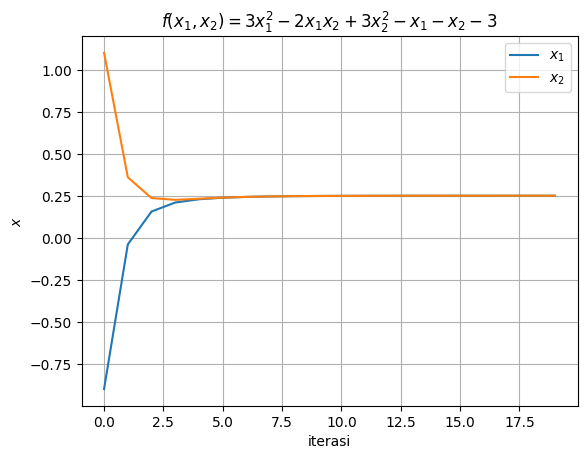

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(list_of_params, label=['$x_1$','$x_2$'])
ax.set_title('$ f(x_1, x_2) = 3x_1^2 - 2x_1x_2 + 3x_2^2 - x_1 - x_2 - 3 $')
ax.set_xlabel('iterasi')
ax.set_ylabel('$x$')
ax.legend()
ax.grid()

### Tampilkan hasilnya

In [5]:
print("nilai x_1 dan x_2 terbaik adalah {:.2f} dan {:.2f}".format(minimized_params[0], minimized_params[1]))

nilai x_1 dan x_2 terbaik adalah 0.25 dan 0.25


- Melakukan optimalisasi lebih sederhana dengan menggunakan PyTorch
- NN paling sesuai untuk menyelesaikan suatu permasalahan regresi dan klasifikasi

## Contoh 2 - Simple Regression Problem

- Misalkan diketahui ada sebanyak 100 data sebagai berikut:

Text(0.5, 1.0, 'Data')

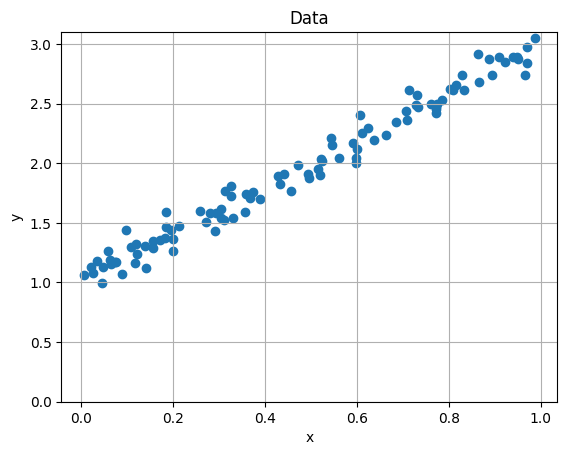

In [6]:
import numpy as np

true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_b + true_w * x + (.1 * np.random.randn(N, 1))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()  
ax.scatter(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim([0, 3.1])
ax.grid()
ax.set_title('Data')

- Bagaimana persamaan regresi, yaitu hubungan antara nilai $x$ terhadap $y$, dari sekumpulan data di atas?
- Pertama, kita coba bisa mendapatkannya **tanpa** menggunakan PyTorch

### Splitting dataset

- Hal yang paling pertama kita lakukan adalah membagi data menjadi 2 bagian, yaitu data train dan data validation

In [7]:
idx = np.arange(N)
np.random.shuffle(idx)

# menggunakan 80 random indeks pertama untuk train
train_idx = idx[:int(N*.8)]

# dan sisanya untuk validation
val_idx = idx[int(N*.8):]

# membagi data train & data validation berdasarkan indeks yang telah dibut
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

- Kita akan menggunakan model regresi yang paling sederhana, yaitu: $$ y = b + wx $$
- Divisualisasikan dalam bentuk neural network dengan 1 input $x$ dan 1 output $y$

![](img/img8.png)

- $x$ disebut sebagai fitur dan $y$ disebut sebagai label
- $b$ adalah bias
- $w$ adalah wight
- $b$ dan $w$ yang akan kita cari nilainya

### Menginisialisasi nilai parameter $b$ dan $w$

- Kita menginisialisasi nilai parameter $b$ dan $w$ secara acak

In [8]:
np.random.seed(42)
b = np.random.randn(1)
w = np.random.randn(1)

print("nilai awal b = {} dan w = {}".format(b,w))

nilai awal b = [0.49671415] dan w = [-0.1382643]


### Menghitung prediksi dari model yang dibuat

- Kita akan menghitung label prediksi $\hat{y}$ dari model yang kita buat berdasarkan parameter $b$ dan $w$ yang telah kita inisialisasi sebelumnya

$$\hat{y} = b + wx$$

In [9]:
yhat = b + w * x_train

### Menghitung nilai loss
- Kita akan menghitung nilai loss antara label prediksi $\hat{y}$ dan label sebenarnya $y$
- Nilai loss didapatkan dari persamaan mean squared error (MSE)

In [10]:
error = (yhat - y_train)
loss = (error ** 2).mean()

print(f"nilai loss = {loss}")

nilai loss = 2.7421577700550976


### Menghitung gradient
- Kita akan menghitung gradient dari kedua parameter $b$ dan $w$

In [11]:
b_grad = 2 * error.mean()
w_grad = 2 * (x_train * error).mean()

### Update nilai parameter $b$ dan $w$
- Terakhir adalah melakukan update nilai parameter $b$ dan $w$ berdasarkan gradient yang telah didapatkan dari langkah sebelumnya
- Di sini kita tentukan berapa nilai learning rate yang akan digunakan

In [12]:
learning_rate = .1

b = b - learning_rate * b_grad
w = w - learning_rate * w_grad

print(f"parameter terbaru adalah b = {b} dan w = {w}")

parameter terbaru adalah b = [0.80119529] dan w = [0.04511107]


- Ulangi langkah di atas hingga beberapa iterasi
- Iterasi pada NN biasa disebut sebagai **epoch**
- Sehingga kode python secara keseluruhan di atas adalah

In [13]:
np.random.seed(42)
b = np.random.randn(1)
w = np.random.randn(1)

print("nilai awal b = {} dan w = {}".format(b,w))

learning_rate = .1
epoch = 1000

for i in range(epoch):
    yhat = b + w * x_train
    
    error = (yhat - y_train)
    loss = (error ** 2).mean()
    
    b_grad = 2 * error.mean()
    w_grad = 2 * (x_train * error).mean()
    
    b = b - learning_rate * b_grad
    w = w - learning_rate * w_grad

print(f"nilai akhir parameter b = {b} dan w = {w}")

nilai awal b = [0.49671415] dan w = [-0.1382643]
nilai akhir parameter b = [1.02354094] dan w = [1.96896411]


- Jika kita visualisasikan model yang telah kita dapatkan, maka grafiknya sebagai berikut:

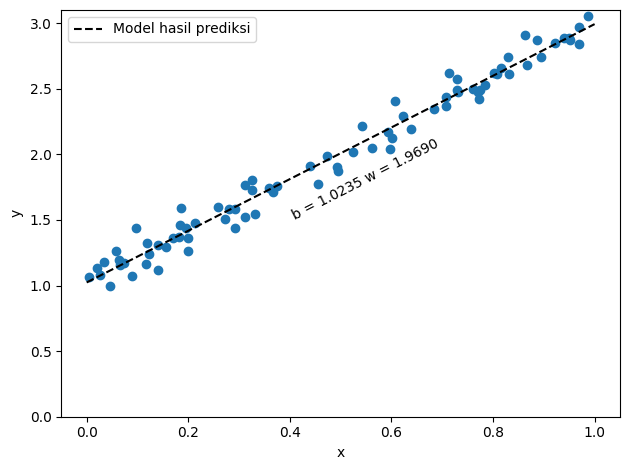

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def figure3(x_train, y_train, b_minimum, w_minimum):
    x_range = np.linspace(0, 1, 101)
    yhat_range = b_minimum + w_minimum * x_range

    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim([0, 3.1])

    ax.scatter(x_train, y_train)
    ax.plot(x_range, yhat_range, label='Model hasil prediksi', c='k', linestyle='--')

    ax.annotate('b = {:.4f} w = {:.4f}'.format(b_minimum[0], w_minimum[0]), xy=(.4, 1.5), c='k', rotation=27)
    ax.legend(loc=0)
    fig.tight_layout()
    return fig, ax

fig = figure3(x_train, y_train, b, w)

- Sekarang kita coba bandingkan antara cara yang telah kita lakukan di atas dengan cara jika kita menggunakan PyTorch

### Splitting dataset

- Jika kita menggunakan PyTorch, maka langkah yang perlu dilakukan setelah membagi data train dan validation adalah mengubah data tersebut ke dalam bentuk PyTorch Tensor

In [15]:
idx = np.arange(N)
np.random.shuffle(idx)

# menggunakan 80 random indeks pertama untuk train
train_idx = idx[:int(N*.8)]

# dan sisanya untuk validation
val_idx = idx[int(N*.8):]

# membagi data train & data validation berdasarkan indeks yang telah dibut
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

In [16]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)
x_val_tensor = torch.as_tensor(x_val).float().to(device)
y_val_tensor = torch.as_tensor(y_val).float().to(device)

### Menginisialisasi nilai parameter $b$ dan $w$

- Kita menginisialisasi nilai parameter $b$ dan $w$ secara acak
- Kita tambahkan juga parameter `requires_grad`

In [17]:
torch.manual_seed(42)

b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
w = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print("nilai awal b = {} dan w = {}".format(b,w))

nilai awal b = tensor([0.3367], requires_grad=True) dan w = tensor([0.1288], requires_grad=True)


### Menghitung prediksi dari model yang dibuat

- Kita akan menghitung label prediksi $\hat{y}$ dari model yang kita buat berdasarkan parameter $b$ dan $w$ yang telah kita inisialisasi sebelumnya

$$\hat{y} = b + wx$$

In [18]:
yhat = b + w * x_train_tensor

### Menghitung nilai loss
- Kita akan menghitung nilai loss antara label prediksi $\hat{y}$ dan label sebenarnya $y$
- Nilai loss didapatkan dari persamaan mean squared error (MSE)
- Kita bisa gunakan `MSELoss` dari PyTorch untuk mendapatkan nilai MSE-nya

In [19]:
from torch import nn

loss_fn = nn.MSELoss(reduction='mean')
loss = loss_fn(yhat, y_train_tensor)
print(f"nilai loss = {loss}")

nilai loss = 2.67405366897583


### Menghitung gradient

- Kita akan menghitung gradient dari kedua parameter $b$ dan $w$
- Pada PyTorch, kita cukup menggunakan method `backward()`

In [20]:
loss.backward()

### Update nilai parameter $b$ dan $w$

- Terakhir adalah melakukan update nilai parameter $b$ dan $w$ berdasarkan gradient yang telah didapatkan dari langkah sebelumnya
- Di sini kita tentukan berapa nilai learning rate yang akan digunakan

In [21]:
from torch import optim

learning_rate = .1

optimizer = optim.SGD([b, w], lr=learning_rate)
optimizer.step()
optimizer.zero_grad()

- Ulangi langkah di atas hingga beberapa iterasi
- Iterasi pada NN biasa disebut sebagai **epoch**
- Sehingga kode python secara keseluruhan di atas adalah

In [25]:
learning_rate = .1

torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

optimizer = optim.SGD([b, w], lr=learning_rate)

loss_fn = nn.MSELoss(reduction='mean')

n_epochs = 1000

for epoch in range(n_epochs):
    yhat = b + w * x_train_tensor
    
    loss = loss_fn(yhat, y_train_tensor)

    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
print(f"parameter terbaru adalah b = {b} dan w = {w}")

parameter terbaru adalah b = tensor([1.0200], requires_grad=True) dan w = tensor([1.9565], requires_grad=True)


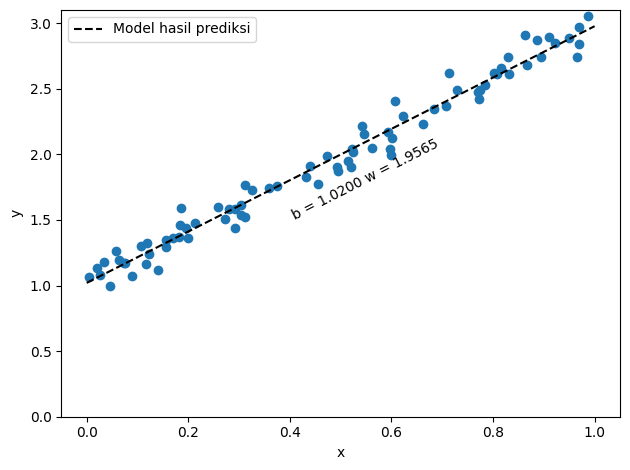

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def figure3(x_train, y_train, b_minimum, w_minimum):
    x_range = np.linspace(0, 1, 101)
    yhat_range = b_minimum + w_minimum * x_range

    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim([0, 3.1])

    ax.scatter(x_train, y_train)
    ax.plot(x_range, yhat_range, label='Model hasil prediksi', c='k', linestyle='--')

    ax.annotate('b = {:.4f} w = {:.4f}'.format(b_minimum[0], w_minimum[0]), xy=(.4, 1.5), c='k', rotation=27)
    ax.legend(loc=0)
    fig.tight_layout()
    return fig, ax

fig = figure3(x_train, y_train, b.detach().numpy(), w.detach().numpy())